# NLP Text Classification: classifying the origin of names using a character-level RNN
# Author: Huygens Ravelomanana

We use a rnn-based model to perform classification.

1. We do text preprocessing.
2. Use embeddings and RNNs in conjunction at the character level to perform classification.
3. Write a function that takes as input a string, and outputs the name of the predicted class.

# Importing libraries

In [1]:
%tensorflow_version 2.x

%matplotlib inline
# to store the plots within the notebook

# uncomment this line below if running on google colab
%tensorflow_version 2.x 

from glob import glob

import re

import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# setting seed for random in order to get reproducible results
random.seed(1)    # python random seed
np.random.seed(1)  # numpy random seed


import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras.metrics import mean_squared_error, mean_absolute_error

from tensorflow.keras.utils import plot_model

import tensorflow.keras.backend as K
import tensorflow as tf

from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (SimpleRNN, LSTM,
                                     GRU, Conv1D, Flatten,
                                     Dense, TimeDistributed,
                                     Bidirectional, Embedding,
                                     BatchNormalization,
                                     Dropout)


from tensorflow.keras import initializers
from tensorflow.keras.optimizers import Adam, Nadam


from keras.callbacks import LearningRateScheduler
from tensorflow.keras import regularizers

sns.set(style="whitegrid")


# Loading data and data exploration.

## Getting the raw data and preliminary exploration
+ Loading the data into local directory from external sources.
+ Exploration using linux commands.

In [2]:
# Download the data
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip

--2021-08-18 02:02:45--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.226.50.24, 13.226.50.77, 13.226.50.63, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.226.50.24|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  15.8MB/s    in 0.2s    

2021-08-18 02:02:46 (15.8 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italia

In [3]:
# listing files and folder in current directory
!ls

data  data.zip	sample_data


In [4]:
# install tree to view directories and files tree
!apt install tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 40 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 0s (116 kB/s)
Selecting previously unselected package tree.
(Reading database ... 148486 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [5]:
!tree

.
├── data
│   ├── eng-fra.txt
│   └── names
│       ├── Arabic.txt
│       ├── Chinese.txt
│       ├── Czech.txt
│       ├── Dutch.txt
│       ├── English.txt
│       ├── French.txt
│       ├── German.txt
│       ├── Greek.txt
│       ├── Irish.txt
│       ├── Italian.txt
│       ├── Japanese.txt
│       ├── Korean.txt
│       ├── Polish.txt
│       ├── Portuguese.txt
│       ├── Russian.txt
│       ├── Scottish.txt
│       ├── Spanish.txt
│       └── Vietnamese.txt
├── data.zip
└── sample_data
    ├── anscombe.json
    ├── california_housing_test.csv
    ├── california_housing_train.csv
    ├── mnist_test.csv
    ├── mnist_train_small.csv
    └── README.md

3 directories, 26 files


In [6]:
# counting the number of files in names
!ls data/names/ | wc -l

18


In [7]:
# looking at Vietnamese names.
!head --lines=30 data/names/Vietnamese.txt

Nguyen
Tron
Le
Pham
Huynh
Hoang
Phan
Vu
Vo
Dang
Bui
Do
Ho
Ngo
Duong
Ly
An
an
Bach
Banh
Cao
Chau
Chu
Chung
Chu
Diep
Doan
Dam
Dao
Dinh


In [8]:
# looking at some English name
!head --lines=30 data/names/English.txt

Abbas
Abbey
Abbott
Abdi
Abel
Abraham
Abrahams
Abrams
Ackary
Ackroyd
Acton
Adair
Adam
Adams
Adamson
Adanet
Addams
Adderley
Addinall
Addis
Addison
Addley
Aderson
Adey
Adkins
Adlam
Adler
Adrol
Adsett
Agar


In [9]:
# looking at some English name
!head --lines=30 data/names/Russian.txt

Ababko
Abaev
Abagyan
Abaidulin
Abaidullin
Abaimoff
Abaimov
Abakeliya
Abakovsky
Abakshin
Abakumoff
Abakumov
Abakumtsev
Abakushin
Abalakin
Abalakoff
Abalakov
Abaleshev
Abalihin
Abalikhin
Abalkin
Abalmasoff
Abalmasov
Abaloff
Abalov
Abamelek
Abanin
Abankin
Abarinoff
Abarinov


In [10]:
# counting the number of names in English
!wc -l < data/names/English.txt

3668


In [11]:
 # counting the number of names in Vietnamese
 !wc -l < data/names/Vietnamese.txt

73


In [12]:
# counting the number of names in Russian
!wc -l < data/names/Russian.txt

9408


In [13]:
# counting the number of names in French
!wc -l < data/names/French.txt

277


In [14]:
# counting the number of names in Arabic
!wc -l < data/names/Arabic.txt

2000


**Comments**
+ The data we need are in `~/data/names`
+ There are 18 languages.
+ The files for some languages contains fewer names than others.
+ The data seems clean at first sight, no weird characters like @, %, # , & *

## Putting the raw data into python objects

In [15]:
# defining a function which open a file read it content
# and store it in a python list.

def get_lines(path):
    """ Function which reads the lines in a file whose path is 
    the input parameter path, then store the lines in a list.

    Input:
    ------
           path (str): a path to a file.
    
    Output:
    -------
           (list): all lines from the files put in a list
                   excluding escape sequence like \n,
    """
    # opening the file
    myfile = open(path)

    # reading the lines
    # and putting them in a list
    content = myfile.readlines()
    content = map(str.strip, content)
    content = list(content)

    # closing the file
    myfile.close()

    return content

In [16]:
# Function that get the names and their origin as a list of
# tuple (name, origin)

def get_names_and_origin():
    """Function which puts the names and origin from the local
    files into list of tuples (name, origins).

    Input:
    ------
            None: The function just opens reads and closes all
                  .txt files in ~/data/names/
    Output:
    ------
           list: A list of tuples of the form (name, origin).
    """

    # creating an empty list to contain the tuples (name, origin)
    data = []
    
    # looping through all the .txt file of ~/data/names/
    for filename in glob('data/names/*.txt'):

        # extracting the language name
        origin = filename.split('/')[-1].split('.txt')[0]

        # getting all the names for the language origin
        names = get_lines(filename)

        # looping through names to pair each name with its language
        for name in names:
            data.append((name, origin))
    
    # shuffling the data 
    # since we do not want names with the same origin
    # to follow one another
    random.shuffle(data)
    
    return data

In [17]:
# creating the list of tuple (name, origin)
names_list =  get_names_and_origin()

In [18]:
# looking at the first 20 tuples in the list
names_list[:20]

[('Tsigra', 'Russian'),
 ('Pyanochenko', 'Russian'),
 ('Delaney', 'English'),
 ('Auton', 'English'),
 ('Eihvald', 'Russian'),
 ('Mifsud', 'Arabic'),
 ('Jamskov', 'Russian'),
 ('Kidner', 'English'),
 ('Lezdinysh', 'Russian'),
 ('Rosario', 'Portuguese'),
 ('Forakis', 'Greek'),
 ('Kabatsky', 'Russian'),
 ('Mordovtsev', 'Russian'),
 ('Norville', 'English'),
 ('Poulter', 'English'),
 ('Can', 'Dutch'),
 ('Imerlishvili', 'Russian'),
 ('Soler', 'Spanish'),
 ('Bianchi', 'Italian'),
 ('Herodes', 'Czech')]

## Separating the data into train_validation data and test data

In [19]:
names, origins = zip(*names_list)
names_train, names_test, orig_train, orig_test = train_test_split(names,
                                                                origins,
                                                                test_size=0.15,
                                                                stratify=origins, 
                                                                shuffle=True,
                                                                random_state=1)

In [20]:
# looking at the newly created train (& validation) data

for name, origin in zip(names_train[:20], orig_train[:20]):
  print(name.ljust(20), origin)

Jarihin              Russian
Abelman              Russian
Sampson              English
Yarlett              English
Kachkov              Russian
Rickards             English
May                  English
Tohill               English
Zolotarev            Russian
Ladyzhensky          Russian
Jarrett              English
Gomez                Spanish
Veligorsky           Russian
Morinaga             Japanese
Pokhmelkin           Russian
Tcharnolusky         Russian
Eroshevsky           Russian
Suárez               Spanish
Antonopoulos         Greek
Sokolowski           Polish


# Text Preprocessing

## Character tokenization

In [21]:
# creating and instance of Tokenizer as lower case character tokenizer
input_tokenizer = Tokenizer(char_level=True, lower=True)

# fitting the Tokenizer on all the names.
# In theory we should fit on the train data only but we are not sure if the 
# train data contains all the possible characters.
input_tokenizer.fit_on_texts(names)

In [22]:
# setting a constant for the number of characters
no_of_char = len(input_tokenizer.word_index)

# printing the number of characters
print("Number of characters: ", no_of_char)

Number of characters:  58


In [23]:
# Looking at all unique characters in the whole data
input_tokenizer.word_index

{' ': 25,
 "'": 27,
 ',': 41,
 '-': 29,
 '/': 56,
 '1': 43,
 ':': 48,
 'a': 1,
 'b': 16,
 'c': 19,
 'd': 15,
 'e': 3,
 'f': 21,
 'g': 18,
 'h': 8,
 'i': 4,
 'j': 23,
 'k': 9,
 'l': 10,
 'm': 14,
 'n': 5,
 'o': 2,
 'p': 22,
 'q': 26,
 'r': 6,
 's': 7,
 't': 12,
 'u': 13,
 'v': 11,
 'w': 24,
 'x': 28,
 'y': 17,
 'z': 20,
 '\xa0': 55,
 'ß': 38,
 'à': 37,
 'á': 35,
 'ã': 46,
 'ä': 33,
 'ç': 54,
 'è': 45,
 'é': 31,
 'ê': 50,
 'ì': 49,
 'í': 32,
 'ñ': 40,
 'ò': 42,
 'ó': 34,
 'õ': 51,
 'ö': 30,
 'ù': 58,
 'ú': 39,
 'ü': 36,
 'ą': 57,
 'ł': 53,
 'ń': 52,
 'ś': 44,
 'ż': 47}

In [24]:
# looking at the count for each of the characters
input_tokenizer.word_counts

OrderedDict([('t', 5956),
             ('s', 7985),
             ('i', 10422),
             ('g', 3217),
             ('r', 8262),
             ('a', 16516),
             ('p', 1711),
             ('y', 3619),
             ('n', 9961),
             ('o', 11106),
             ('c', 3070),
             ('h', 7688),
             ('e', 10764),
             ('k', 6922),
             ('d', 3899),
             ('l', 6713),
             ('u', 4720),
             ('v', 6315),
             ('m', 4351),
             ('f', 1778),
             ('j', 1351),
             ('z', 1932),
             ('b', 3657),
             ('w', 1127),
             ('x', 73),
             ('q', 98),
             ("'", 87),
             ('ä', 13),
             ('ö', 24),
             ('í', 14),
             (' ', 115),
             ('é', 23),
             ('-', 25),
             ('ó', 13),
             (',', 3),
             ('ß', 9),
             ('ò', 3),
             (':', 1),
             ('á', 13),
             ('

In [25]:
# listing the number of names
input_tokenizer.document_count

20074

In [26]:
# creating numerical tokens for the sake of exploration
token_list = input_tokenizer.texts_to_sequences(names)

In [27]:
# looking at the first 10 samples
token_list[:10]

[[12, 7, 4, 18, 6, 1],
 [22, 17, 1, 5, 2, 19, 8, 3, 5, 9, 2],
 [15, 3, 10, 1, 5, 3, 17],
 [1, 13, 12, 2, 5],
 [3, 4, 8, 11, 1, 10, 15],
 [14, 4, 21, 7, 13, 15],
 [23, 1, 14, 7, 9, 2, 11],
 [9, 4, 15, 5, 3, 6],
 [10, 3, 20, 15, 4, 5, 17, 7, 8],
 [6, 2, 7, 1, 6, 4, 2]]

In [28]:
# looking at the last 10 samples
token_list[-10:]

[[22, 1, 20, 13, 8, 4, 5],
 [6, 13, 15, 1, 7, 9, 4],
 [5, 2, 6, 14, 4, 5, 18, 12, 2, 5],
 [23, 3, 6, 2, 14, 3],
 [12, 3, 14, 22, 3, 7, 12],
 [18, 6, 2, 7, 7, 8, 2, 22, 21],
 [12, 13, 6, 4, 17, 1, 5, 7, 9, 17],
 [16, 1, 7, 12, 4, 1, 5],
 [12, 2, 13, 14, 1],
 [8, 2, 14, 4, 19, 8, 3, 5, 9, 2]]

## Features Vectorization
We are going to vectorize the train & validation and the test data

In [29]:
#getting the length of the longest word/name
max_name_length =  max([len(x) for x in token_list])

# printing the length of the longest word
print("Number of characters for the longest name: ",
      max_name_length)

Number of characters for the longest name:  20


In [30]:

def vectorize_features(our_list):
    """
    Function converting all the tokens in the input our_list
    into sequence of numbers, then padding the result,
    making them the same length as the longest word by
    adding zeroes to fill the gap. Finally it convert the
    result into a numpy.array and returns it

    Input:
    -----
        our_list  (list): a list of characters tokens.

    Ouput:
    -----
        numpy.array: shape= (number of samples, max_name_length)
                    the vectorized and padded data.
    """

    # converting list of characters into list of integers 
    our_X = input_tokenizer.texts_to_sequences(our_list)

    # doing the padding
    our_X = np.array(pad_sequences(our_X,
                                maxlen=max_name_length,
                                padding='pre'))

    return our_X

In [31]:
# vectorizing the train_validation and the test features
X_train_val = vectorize_features(names_train)
X_test = vectorize_features(names_test)

In [32]:
# looking at the shape
X_train_val.shape, X_test.shape

((17062, 20), (3012, 20))

In [33]:
# looking at the first 10 samples of X_train_val
X_train_val[:10]

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 23,  1,  6,
         4,  8,  4,  5],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1, 16,  3,
        10, 14,  1,  5],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  7,  1, 14,
        22,  7,  2,  5],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 17,  1,  6,
        10,  3, 12, 12],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  9,  1, 19,
         8,  9,  2, 11],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  6,  4, 19,  9,
         1,  6, 15,  7],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0, 14,  1, 17],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 12,  2,
         8,  4, 10, 10],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 20,  2, 10,  2, 12,
         1,  6,  3, 11],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 10,  1, 15, 17, 20,  8,  3,
         5,  7,  9, 17]], dtype=int32)

In [34]:
# looking at the last 10 samples
X_train_val[-10:]

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 15,  2,
         5,  9,  4,  5],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  5,  4,  7,  8,  4,
        14, 13,  6,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  3, 14,
        12,  7,  2, 11],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0, 17, 13,  3],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 19,  1, 10, 10,  1,
        18,  8,  1,  5],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 14, 13, 20,  1, 21,
         1,  6,  2, 11],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 18,  1,
        14, 14,  3,  6],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 14, 13,  7,
        12,  1, 21,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 16,  1,
         7,  1,  6,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 11,  4, 10, 10,  1, 10,
         2, 16,  2,  7]], dtype=int32)

In [35]:
# checking if indeed all the element in the data have the same length.
#np.array([len(x)==max_name_length for x in token_list]).all()

## Categorizing the labels / Targets

In [36]:
# creating a numpy array containing the origins for the train data
orig_train_arr = np.array(orig_train)

# create an instance of LabelEncoder to be used for convertin the
# strings into numerical labels
label_encoder = LabelEncoder()

# fiting the LabelEncoder instance on the train origins data
orig_train_num = label_encoder.fit_transform(orig_train_arr)

# fiting the LabelEncoder instance on the train origins data
orig_test_num = label_encoder.fit_transform(orig_test)


In [37]:
# looking at the classes seeing if it contains all of them.
label_encoder.classes_

array(['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French',
       'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean',
       'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish',
       'Vietnamese'], dtype='<U10')

In [38]:
# checking inverse_transform
label_encoder.inverse_transform(list(range(18)))

array(['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French',
       'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean',
       'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish',
       'Vietnamese'], dtype='<U10')

In [39]:
# creating the a train and validation target / label as 
# a hot-encoded  vectors
y_train_val = to_categorical(orig_train_num)

# doing the same for the test data
y_test = to_categorical(orig_test_num)
 
# checking the shape of the result
y_train_val.shape,  y_test.shape

((17062, 18), (3012, 18))

In [40]:
# looking at the first 3 samples
y_train_val[:3]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]], dtype=float32)

# Separating the train and validation data
+ We do this to avoid the randomness in validation_split. We use a predefine fixed validation data.

In [41]:

X_train, X_val, y_train, y_val = train_test_split(X_train_val,
                                                   y_train_val,
                                                   test_size=0.15,
                                                   stratify=y_train_val,
                                                   shuffle=True,
                                                   random_state=1)

# Modeling Training and Testing

## Utility functions

In [42]:
# Creating a function which plots loss or accuracy curve
def plot_train_val_curves(history):
    """Function plotting the train and validation loss and accuracy curves
    INPUT:
    -----   
            history (tensorflow.python.keras.callbacks.History):
                     output of the .fit() method of a keras Model instance
    OUTPUT:
    ------
            None (it shows some plots)
    """

    # creating figure and axis for the plot
    fig, axes = plt.subplots(1,2, figsize=(20,8))

    # train and validation loss plot
    axes[0].plot(history.history['loss'])
    axes[0].plot(history.history['val_loss'])
    axes[0].set_title('Model Loss Progress During Training', fontsize=15)
    axes[0].set_ylabel('Training and Validation Loss', fontsize=12)
    axes[0].set_xlabel('Epoch number', fontsize=12)
    axes[0].legend(['Training Loss', 'Validation Loss'], fontsize=12)

    # train and validation accuracy plot
    axes[1].plot(history.history['accuracy'])
    axes[1].plot(history.history['val_accuracy'])
    axes[1].set_title('Model accuracy Progress During Training', fontsize=15)
    axes[1].set_ylabel('Training and Validation accuracy', fontsize=12)
    axes[1].set_xlabel('Epoch number', fontsize=12)
    axes[1].legend(['Training accuracy', 'Validation accuracy'], fontsize=12)

    plt.show()



## Creating and training the model

In [43]:
from tensorflow.keras import regularizers


In [104]:
def create_model():
    """ Creates an custom Made LSTM model
    Input:
    ------  None

    Output:
    ------
          (tensorflow.python.keras.engine.sequential.Sequential)
                 a compiled model.
    """

    ########## Creating the model ############################################
    # creating a new instance of Sequential
    model = Sequential()

    model.add(Embedding(no_of_char+1, 180, input_length=max_name_length))
    model.add(Bidirectional(GRU(260,
                                return_sequences=True,
                                activity_regularizer=regularizers.l2(1e-2))))
    model.add(Dropout(0.3))

    model.add(Bidirectional(LSTM(180,return_sequences=True)))

    model.add(Dropout(0.4))

    # model.add(Dense(50,
    #                 activation='relu'))
    model.add(Bidirectional(LSTM(90,return_sequences=True)))

    model.add(Dropout(0.4))

    model.add(Bidirectional(LSTM(40)))

    model.add(Dropout(0.4))

    model.add(Dense(18, activation='softmax'))

    ########## End Creaction ############################################

    # Compiling the model

    # specifying an optimizer
    optimizer = Nadam(learning_rate=0.001,
                      beta_1 = 0.75,
                      beta_2 = 0.8)
    
    # compiling
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    
    return model


In [105]:
# defining a learning rate scheduler function
# we will also use this for the other times of model
def scheduler(epoch, lr):
    """ Learning rate scheduler
    INPUT:
    ------         
          epochs (int): current number of epoch.

          lr (float): initial learning rate
    
    OUTPUT:
    -------
          (float) learning rate for the corresponding epoch
    """

    if epoch < 11: 
        return lr
    else:
        return lr * tf.math.exp(0.5*(10-epoch))

In [106]:
%%time

K.clear_session()

# setting seed for random in order to get reproducible results
tf.random.set_seed(1)
np.random.seed(1)

# we are using early stopping callback to prevent the model from
# training for more epochs than needed, it will save time and resources.
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                              patience=3)

# learning rate scheduler
lambda_scheduler = lambda _ : scheduler( _ , 0.001)
lr_sched = LearningRateScheduler(lambda_scheduler)

# creating the compiled model
model = create_model()

# training the model
history = model.fit(X_train,
                    y_train,
                    batch_size=32,
                    epochs=100,
                    validation_data=(X_val, y_val),
                    callbacks=[lr_sched, early_stop],
                    verbose=2)


Epoch 1/100
454/454 - 28s - loss: 1.4756 - accuracy: 0.5902 - val_loss: 1.2161 - val_accuracy: 0.6535
Epoch 2/100
454/454 - 11s - loss: 1.1794 - accuracy: 0.6757 - val_loss: 1.1008 - val_accuracy: 0.6848
Epoch 3/100
454/454 - 11s - loss: 1.0827 - accuracy: 0.7048 - val_loss: 1.0156 - val_accuracy: 0.7109
Epoch 4/100
454/454 - 11s - loss: 1.0093 - accuracy: 0.7220 - val_loss: 0.9416 - val_accuracy: 0.7473
Epoch 5/100
454/454 - 11s - loss: 0.9467 - accuracy: 0.7458 - val_loss: 0.8916 - val_accuracy: 0.7539
Epoch 6/100
454/454 - 11s - loss: 0.8943 - accuracy: 0.7574 - val_loss: 0.8840 - val_accuracy: 0.7578
Epoch 7/100
454/454 - 11s - loss: 0.8630 - accuracy: 0.7675 - val_loss: 0.8674 - val_accuracy: 0.7641
Epoch 8/100
454/454 - 11s - loss: 0.8158 - accuracy: 0.7800 - val_loss: 0.8086 - val_accuracy: 0.7836
Epoch 9/100
454/454 - 11s - loss: 0.7862 - accuracy: 0.7922 - val_loss: 0.8218 - val_accuracy: 0.7816
Epoch 10/100
454/454 - 11s - loss: 0.7596 - accuracy: 0.7935 - val_loss: 0.7354 - 

In [107]:
# printing a summary of the model
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 180)           10620     
_________________________________________________________________
bidirectional (Bidirectional (None, 20, 520)           689520    
_________________________________________________________________
dropout (Dropout)            (None, 20, 520)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 20, 360)           1009440   
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 360)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 20, 180)           324720    
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 180)           0

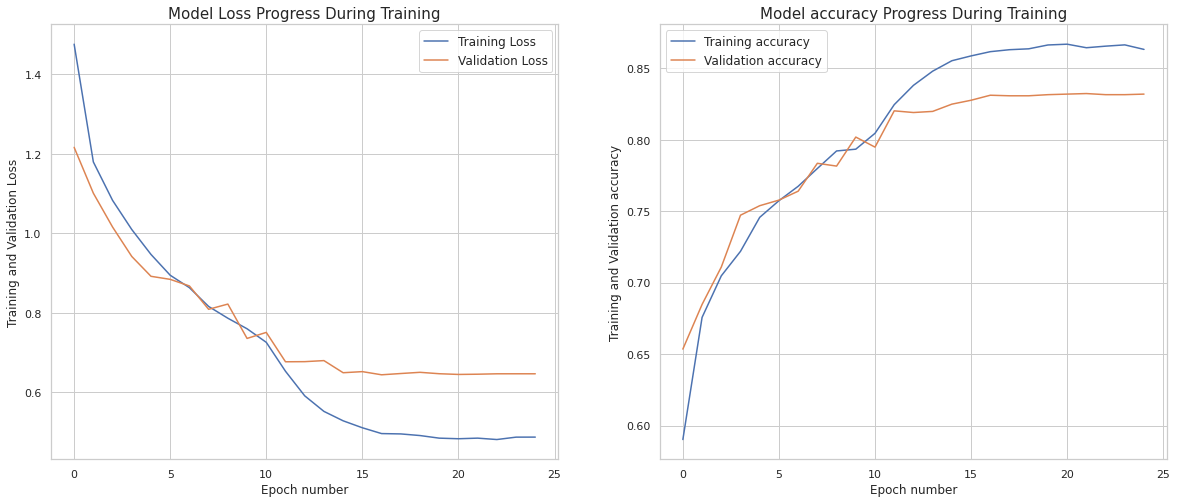

In [108]:
# plotting the train vs validation loss and accuracy
plot_train_val_curves(history)

## Evaluating on Unseen data (Test data)

In [109]:
# Colorful outputs
class bcolors:
    RED       = '\033[91m'
    OKBLUE    = '\033[94m'
    GREEN = '\033[32m'
    BOLD      = '\033[1m'
    UNDERLINE = '\033[4m'
    ENDC      = '\033[0m'

In [110]:
# importing multiple evaluation functions from scikit learn
from sklearn.metrics import accuracy_score, classification_report

In [111]:
test_result = model.evaluate(X_test, y_test)
print("Test loss: ", test_result[0])
print("Test Accuracy: ", test_result[1])

95/95 [==============================] - 3s 9ms/step - loss: 0.6384 - accuracy: 0.8267
Test loss:  0.6384338736534119
Test Accuracy:  0.8266932368278503


In [112]:
# predicting the classes corresponding to the test features
y_pred = model.predict(X_test)

# converting the hot encoded values into single digit class label
pred_labels = np.argmax(y_pred, axis=1) 
y_test_label = np.argmax(y_test, axis=1)
pred_labels, y_test_label

(array([14, 14,  4, ...,  4, 14,  4]), array([14, 14,  4, ...,  4, 14,  4]))

In [113]:
print(bcolors.BOLD + bcolors.OKBLUE +\
      "\nDETAILED TEST SUMMARY:"\
      + bcolors.ENDC + bcolors.ENDC)

# Printing test scores and report
print(bcolors.BOLD + bcolors.GREEN +\
      '\n Test Accuracy: ' + bcolors.ENDC + bcolors.ENDC,
      accuracy_score(y_test_label, pred_labels))

print(bcolors.BOLD + bcolors.GREEN +\
      '\n Classification Report: \n ' + bcolors.ENDC + bcolors.ENDC,
      classification_report(y_test_label,
                            pred_labels,
                            target_names=label_encoder.classes_,
                            zero_division=0))


DETAILED TEST SUMMARY:

 Test Accuracy:  0.8266932270916335

 Classification Report: 
                precision    recall  f1-score   support

      Arabic       0.95      1.00      0.97       300
     Chinese       0.48      0.80      0.60        40
       Czech       0.55      0.40      0.46        78
       Dutch       0.56      0.33      0.42        45
     English       0.72      0.85      0.78       550
      French       0.46      0.15      0.22        41
      German       0.49      0.47      0.48       109
       Greek       0.77      0.67      0.71        30
       Irish       0.63      0.34      0.44        35
     Italian       0.68      0.75      0.71       106
    Japanese       0.86      0.87      0.87       149
      Korean       0.00      0.00      0.00        14
      Polish       0.69      0.43      0.53        21
  Portuguese       0.00      0.00      0.00        11
     Russian       0.94      0.93      0.94      1412
    Scottish       0.00      0.00      0.00   

###**Comments**
+ The model can predict some laguages more than others.
+ There are some languages the model cannot predict, this is probably due to lack of data / names from these laguages in our training set.
+ English names and Russian names are predominant in the samples so they are the 2 languages having the heighest precision and recall.

# Origin prediction function for end user

In [114]:
# defining a function which predict the origin 
# of a name given by the user as input
def predict_origin(name):
    """Function returning the predicted origin of a name (the input)
    
    Input:
    ------
           name (str): a name.
    
    Output:
    ------
           (str): the language of origin of the name from the input.
    """

    # check if the input is indead a string
    assert isinstance(name, str)

    # converting the name string into list of numbers
    input_seq = input_tokenizer.texts_to_sequences([name])

    # padding the list (making it the same lengeth as the longest word,
    # adding zero for the remaining spots) then converting the result
    # to numpy array
    input_seq = np.array(pad_sequences(input_seq,
                                    maxlen=max_name_length,
                                    padding='pre'))
    
    # predicting using the model we have created
    # the result will be a 1D array of probability values
    y_pred = model.predict(input_seq)

    # getting the numerical label for the prediction
    # that is the index for the max probability
    the_origin = np.argmax(y_pred)

    # converting the numerical label to string (language name).
    the_origin = label_encoder.inverse_transform([the_origin])

    # the_origin is an array of 1 element so we just return
    # element
    return the_origin[0]

In [146]:
# predicting some name origin using the above function
names_list = ["Pierre", "Poporski", "Vu", "Vladimir"]

for name in names_list:
    print("\n", name+':',
          predict_origin(name))


 Pierre: English

 Poporski: Polish

 Vu: Chinese

 Vladimir: Russian


**Comment**
+ The `predict_origin` function was not able to recognize that 'Vu' is a Vietnamese name and 'Pierre' as a French name.<br>
We are going to create a new function which outputs 3 probable origins instead of just 1 possible origin.

In [117]:
# defining a function which output 3 possible origins
# for a name given as input
def predict_possible_origins(name):
    """Function returning the top 3 predicted possible origins
       of a name (the input) in decreasing order of probability.
    
    Input:
    ------
           name (str): a name.
    
    Output:
    ------
           numpy.array: an array consisting of the top 3 most
                  (predicted ) possible origins of the name in decreasing
                  order of probability.
    """

    # check if the input is indead a string
    assert isinstance(name, str)

    # converting the name string into list of numbers
    input_seq = input_tokenizer.texts_to_sequences([name])

    # padding the list (making it the same lengeth as the longest word,
    # adding zero for the remaining spots) then converting the result
    # to numpy array
    input_seq = np.array(pad_sequences(input_seq,
                                    maxlen=max_name_length,
                                    padding='pre'))
    
    # predicting using the model we have created
    # the result will be a 1D array of probability values
    y_pred = model.predict(input_seq)[0]
    y_pred = y_pred.reshape(-1,)

    # getting the numerical label for the prediction
    # that is the index for the top 3 max probability
    top3_origins = y_pred.argsort()[-3:]

    # .argsort() list the indices of smallest element first etc...
    # so we need to reverse the order for it to be in decreasing
    # order of probability
    top3_origins = top3_origins[::-1]

    # converting the numerical label to string (language name).
    top3_origins = label_encoder.inverse_transform(top3_origins)

    # the_origin is an array of 1 element so we just return
    # element
    return top3_origins

In [147]:
# predicting some name origin using the above function
names_list = ["Pierre", "Poporski", "Vu", "Mustafa", "Vladimir"]

for name in names_list:
    print("\n", name+':',
          predict_possible_origins(name))


 Pierre: ['English' 'French' 'German']

 Poporski: ['Polish' 'Czech' 'Russian']

 Vu: ['Chinese' 'Korean' 'Vietnamese']

 Mustafa: ['Arabic' 'English' 'Japanese']

 Vladimir: ['Russian' 'Czech' 'English']


**Creating interactive versions**


In [122]:
def query_name_origin():
    """This function asks the user to input a name then print the possible
    origin of the name.
    """

    # taking the name from the user
    name = input("Please enter a name:\t")

    # predicting the origin
    origin = predict_origin(name)

    # printing the origin on the screen
    print("The origin of this name is:  {}".format(origin))

In [123]:
# testing the query_name_origin() function
#query_name_origin()

Please enter a name:	Vu
The origin of this name is:  Chinese


In [124]:
def query_name_origin_2():
    """This function asks the user to input a name then print 3 possible
    origins of the name.
    """

    # taking the name from the user
    name = input("Please enter a name:\t")

    # predicting the 3 possible origins
    origins = predict_possible_origins(name)

    # printing the origin on the screen
    print("\nThe origin of this name is one of these:\n\n {}, {}, {}".format(
                                                                  origins[0],
                                                                  origins[1],
                                                                  origins[2]))

In [125]:
#query_name_origin_2()

Please enter a name:	Vu

The origin of this name is one of these:

 Chinese, Korean, Vietnamese
